In this notebook, I have implemented a basic Actor-Critic model for the  Cartpole-v1 environment. This implementation is heavely inspired by the approach detailed in this [notebook](https://keras.io/examples/rl/actor_critic_cartpole/)

<ipython-input-48-caab8080544d>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  critic_losses.append(self.huber_loss(torch.tensor(value), torch.tensor(ret)))


Running reward: 11.86 at episode 10
Running reward: 17.50 at episode 20
Running reward: 22.27 at episode 30
Running reward: 38.00 at episode 40
Running reward: 44.14 at episode 50
Running reward: 128.22 at episode 60
Running reward: 228.79 at episode 70
Running reward: 254.63 at episode 80
Running reward: 168.15 at episode 90
Running reward: 120.03 at episode 100
Running reward: 140.36 at episode 110
Running reward: 272.88 at episode 120
Running reward: 364.02 at episode 130
Running reward: 418.58 at episode 140
Running reward: 451.25 at episode 150
Running reward: 300.87 at episode 160
Running reward: 188.15 at episode 170
Running reward: 118.05 at episode 180
Running reward: 78.46 at episode 190
Running reward: 55.01 at episode 200
Running reward: 41.40 at episode 210
Running reward: 33.96 at episode 220
Running reward: 29.35 at episode 230
Running reward: 27.48 at episode 240
Running reward: 26.94 at episode 250
Running reward: 26.56 at episode 260
Running reward: 26.89 at episode 2

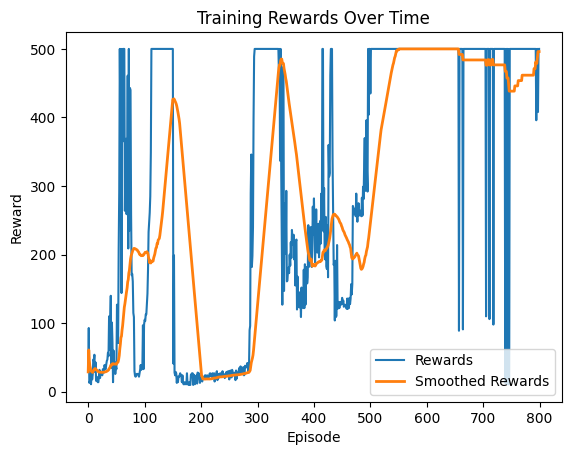

In [48]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

seed = 42
gamma = 0.99
max_steps_per_episode = 10000
env = gym.make("CartPole-v1")
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0
torch.manual_seed(seed)
np.random.seed(seed)

class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.actor = nn.Linear(128, action_size)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        action_probs = torch.softmax(self.actor(x), dim=-1)
        critic_value = self.critic(x)
        return action_probs, critic_value

class ActorCriticAgent:
    def __init__(self, env, gamma, lr):
        self.env = env
        self.gamma = gamma
        self.model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.huber_loss = nn.SmoothL1Loss()
        self.eps = np.finfo(np.float32).eps.item()

    def train(self, max_episodes=1000):
        action_probs_history = []
        critic_value_history = []
        rewards_history = []
        running_reward = 0
        episode_count = 0
        rewards_over_time = []

        while episode_count < max_episodes:
            state = self.env.reset()
            episode_reward = 0

            for timestep in range(max_steps_per_episode):
                state = torch.FloatTensor(state)
                state = state.unsqueeze(0)

                action_probs, critic_value = self.model(state)
                critic_value_history.append(critic_value.item())

                # Sample action from action probability distribution
                action = np.random.choice(self.env.action_space.n, p=np.squeeze(action_probs.detach().numpy()))
                action_probs_history.append(torch.log(action_probs.squeeze(0)[action]))

                state, reward, done, _ = self.env.step(action)
                rewards_history.append(reward)
                episode_reward += reward

                if done:
                    break

            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
            rewards_over_time.append(episode_reward)

            # Calculate expected value from rewards
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + self.gamma * discounted_sum
                returns.insert(0, discounted_sum)

            # Normalize
            returns = torch.tensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + self.eps)

            # Calculating loss values to update our network
            history = zip(action_probs_history, critic_value_history, returns)
            actor_losses = []
            critic_losses = []
            for log_prob, value, ret in history:
                advantage = ret - value
                actor_losses.append(-log_prob * advantage)
                critic_losses.append(self.huber_loss(torch.tensor(value), torch.tensor(ret)))

            loss_value = torch.stack(actor_losses).sum() + torch.stack(critic_losses).sum()

            self.optimizer.zero_grad()
            loss_value.backward()
            self.optimizer.step()

            # Clear the loss and reward history
            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

            episode_count += 1
            if episode_count % 10 == 0:
                print(f'Running reward: {running_reward:.2f} at episode {episode_count}')


        self.plot_rewards(rewards_over_time)

    def plot_rewards(self, rewards, window=50):
        smoothed_rewards = [np.mean(rewards[max(0, i - window):(i + 1)]) for i in range(len(rewards))]
        plt.plot(rewards, label='Rewards')
        plt.plot(smoothed_rewards, label='Smoothed Rewards', linewidth=2)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Training Rewards Over Time')
        plt.legend()
        plt.show()


agent = ActorCriticAgent(env, gamma=gamma, lr=1e-2)
agent.train(max_episodes= 800)